In [111]:
import boto3
import numpy as np
import pandas as pd
from sagemaker import get_execution_role
import matplotlib.pyplot as plt
import seaborn as sns


role = get_execution_role()
bucket='hack4med'

przyjecie_file = 'CRACoV-PRZYJECIE.csv'
biochemia_file = 'CRACoV-BIOCHEMIA_3.csv'
echo_file = 'CRACoV-ECHO.csv'
nefro_file = '_CRACoV-NEFRO.csv'
mapowanie_tomografii_file = 'CRACoV-MAPOWANIE-TOMOGRAFII.csv'
radio_file = 'CRACoV-RADIO.csv'
etykiety_file = 'CRACoV-ETYKIETY.csv'

def load_csv(file, skiprows=0):
    data_location = 's3://{}/{}'.format(bucket, file)
    return pd.read_csv(data_location, skiprows=skiprows)

# tutaj mamy wszystkie wczytane dane
przyjecia = load_csv(przyjecie_file)
biochemia = load_csv(biochemia_file)
echo = load_csv(echo_file)
# nefro ma zwalony pierwszy wiersz
nefro = load_csv(nefro_file, 1)
mapowanie_tomografii = load_csv(mapowanie_tomografii_file)
radio = load_csv(radio_file)
etykiety = load_csv(etykiety_file)

def clean_data(df):
    df = df.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)
    
    df = df.replace('nie', 0)
    df = df.replace('nie wiadomo', 1)
    df = df.replace('tak', 2)
    
    df = df.replace('covid', 1)
    df = df.replace('inny (współistniejący covid)', 1)
    
    df = df.fillna(0)
    return df

def lpAndidLabToInt(df):
    return df.astype({"LP.": int, "ID_LAB": int})

def createId(df):
    df["ID"] = df["LP."] + 100000*df["ID_LAB"]
    df = df.astype({"ID": int})
    df.drop('LP.', inplace=True, axis=1)
    df.drop('ID_LAB', inplace=True, axis=1)
    return df

def load_and_parse(file):
    df = load_csv(file)
    df = clean_data(df)
    df = lpAndidLabToInt(df)
    df = createId(df)
    return df





def load_przyjecia():
    df = load_and_parse(przyjecie_file)
    df = df.astype({"WIEK": int, "PRZENIESIENIE": int, "HOSP_PRZYCZ": int, "NT": int, "DM": int, "ASTMA": int, "POCHP": int, "HF": int, "AF": int, "UDAR": int, "CHD": int, "MI": int, "ZAP_PLUC": int, "PCHN": int, "DEKSAMETEZON": int, "HDCZ": int, "BB": int, "STATYNA": int, "ASA": int, "NOAC": int, "MRA": int, "ACE": int, "SARTANY": int, "CA_BLOKER": int})
    df = df.filter(items=['ID', 'PLEC', 'WIEK', 'WZROST', 'PRZENIESIENIE', 'HOSP_PRZYCZ', 'MASA_CIALA', 'BMI', 'RRS', 'RRD', 'PO2_ATM', 'ODDECH', 'AS', 'NT', 'DM', 'ASTMA', 'POCHP', 'HF', 'AF', 'UDAR', 'CHD', 'MI', 'ZAP_PLUC', 'PCHN', 'DEKSAMETEZON', 'HDCZ', 'BB', 'STATYNA', 'ASA', 'NOAC', 'MRA', 'ACE', 'SARTANY', 'CA_BLOKER'])
    return df

def load_biochemia():    
    df = load_and_parse(biochemia_file)
    df = df.filter(items=['ID', 'KOD', 'WYNIK'])
    df = df.drop_duplicates(subset=['ID', 'KOD'], keep='last')
    df = df.pivot(index="ID", columns="KOD", values="WYNIK")
    df = df.applymap(lambda x: x.replace('<', '') if isinstance(x, str) else x)
    df = df.applymap(lambda x: x.replace('>', '') if isinstance(x, str) else x)
    df = df.applymap(lambda x: x.replace(',', '.') if isinstance(x, str) else x)
    df = df.applymap(lambda x: x.replace(' mg/l', '') if isinstance(x, str) else x)
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    df = df.astype({"n58.11.11342_pct": float, 'i81.11.1112_crp': float, 'g49.122.1113_dd': float, 'm05_il-6': float, 'o59_tnhs': float, 'n11.126.20.1cito_mlecz': float, 'm37.11.191_krea': float, 'c55.103.02_wbc': float, 'c55.103.02_plt': float})
    return df


def load_echo():
    df = load_and_parse(echo_file)
    return df

# def load_nefro():
#     return load_csv(nefro_file, 1)

def load_mapowanie_tomografii():
    df = load_and_parse(mapowanie_tomografii_file)
    return df


def load_radio():
    df = load_and_parse(radio_file)
    return df


def load_etykiety():
    df = load_and_parse(etykiety_file)
    return df



def all_data():
    joined = pd.merge(load_przyjecia(), load_biochemia(), on=["ID"], how='outer')
    joined = pd.merge(joined, load_echo(), on=["ID"], how='outer')
    joined = pd.merge(joined, load_mapowanie_tomografii(), on=["ID"], how='outer')
    joined = pd.merge(joined, load_radio(), on=["ID"], how='outer')
    joined = pd.merge(joined, load_etykiety(), on=["ID"], how='outer')
    joined = joined.fillna(0)
    return joined

data = all_data()

cols = ['WIEK', 'n58.11.11342_pct', 'g49.122.1113_dd', 'm05_il-6', 'o59_tnhs', 'm37.11.191_krea', 'c55.103.02_wbc', 'WZROST', 'MASA_CIALA', 'BMI', 'PCHN', 'DEKSAMETEZON', 'MRA', 'ZGON_LUB_OIT']
data = data.filter(cols)

data

,WIEK,n58.11.11342_pct,g49.122.1113_dd,m05_il-6,o59_tnhs,m37.11.191_krea,c55.103.02_wbc,WZROST,MASA_CIALA,BMI,PCHN,DEKSAMETEZON,MRA,ZGON_LUB_OIT
0,84,0.48,0.76,103.90,20.37,95.6,6.73,178.0,65.0,20.51,2,0,0,1
1,83,0.00,0.00,0.00,0.00,0.0,0.00,170.0,75.0,25.95,2,0,0,0
2,78,1.75,2.38,137.80,254.85,121.0,8.09,178.0,90.0,28.40,0,0,0,1
3,76,9.25,35.20,1781.00,36.08,50.2,10.53,178.0,75.0,23.67,0,0,1,1
4,72,0.00,0.00,0.00,0.00,0.0,0.00,163.0,77.0,28.98,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,65,0.00,0.00,0.00,0.00,0.0,0.00,168.0,102.0,36.13,0,0,0,0
496,77,0.00,0.00,0.00,0.00,0.0,0.00,171.0,86.0,29.41,0,0,0,1
497,58,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0,0,0,0
498,66,0.20,0.95,97.19,6.36,80.5,5.94,167.0,93.2,33.41,0,0,0,1


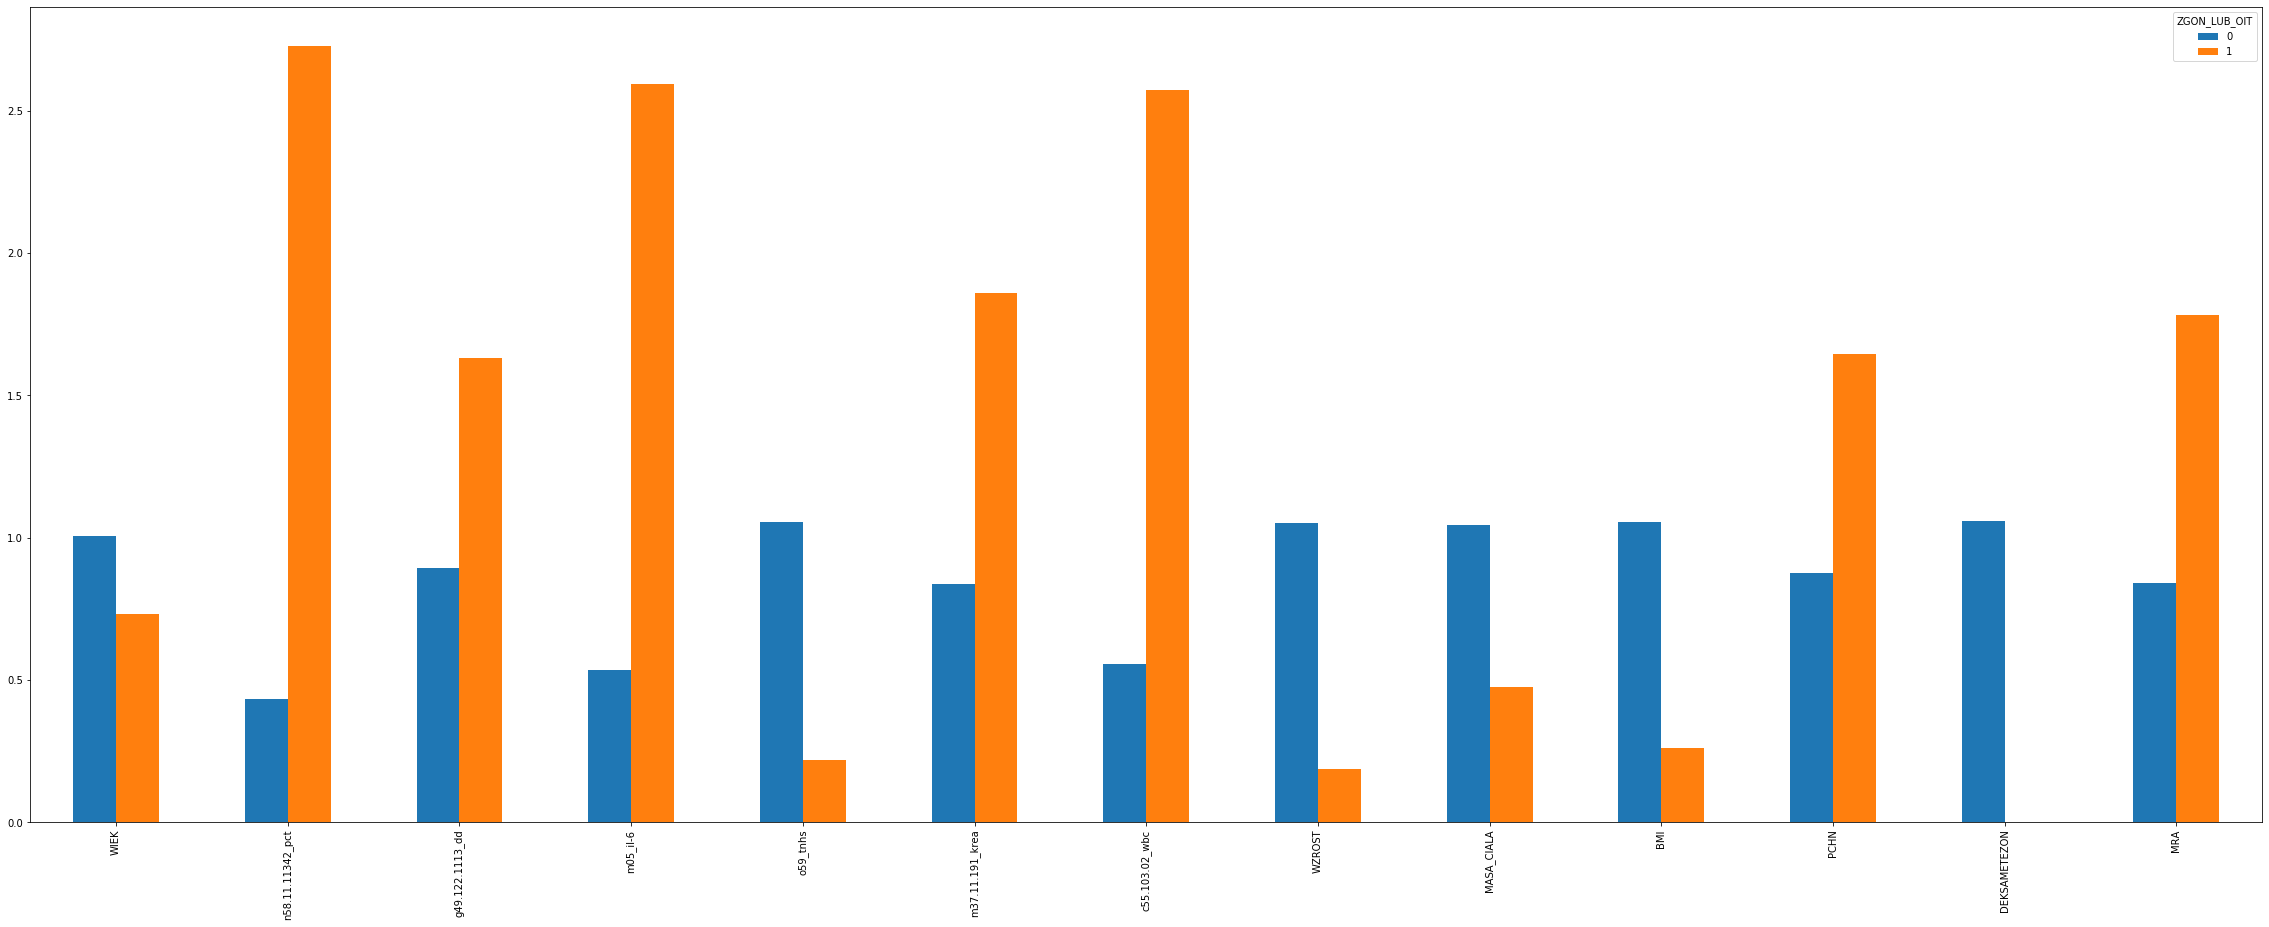

In [112]:
normalized=(data - data.mean()) / data.std()
normalized['ZGON_LUB_OIT'] = data['ZGON_LUB_OIT']

vars = normalized.groupby('ZGON_LUB_OIT').std()

vars.reset_index()

vars = vars.transpose()

vars.plot.bar(figsize=(40, 15))